In [1]:
import numpy as np
from find_indices_cython import find_indices

import ot
from ot.datasets import make_1D_gauss as gauss



2023-10-10 13:03:30.157157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
import numpy as np
import timeit

# Cython-optimized function
def find_indices_cython(X, Y):
    return find_indices(X, Y)

# Ordinary Pythonic version
def find_indices_python(X, Y):
    result = []
    i = 1
    j = 1

    while i < X.shape[0] and j < Y.shape[0]:
        if X[i] > Y[j-1] and Y[j] > X[i-1]:
            result.append((i, j))
            i += 1
        elif X[i] <= Y[j-1]:
            i += 1
        else:
            j += 1

    return result


# Pure NumPy version
def find_indices_numpy(X, Y):
    indices = np.nonzero((X[:,None] > Y[None,:]) & (Y[None,:] > X[:,None]))
    return indices

# Compiled JAX version  
from jax import jit
import jax.numpy as jnp
def find_indices_jax(X, Y):
    indices = jnp.nonzero((X[:,None] > Y[None,:]) & (Y[None,:] > X[:,None]), size = 2*len(X))
    return indices
find_indices_jax = jit(find_indices_jax)


# Sample data -- random, sorted and np.float32
X = np.sort(np.random.randn(100).astype(np.float32))
Y = np.sort(np.random.randn(100).astype(np.float32))



# Compare runtimes
cython_time = timeit.timeit(lambda: find_indices_cython(X, Y), number=100)
python_time = timeit.timeit(lambda: find_indices_python(X, Y), number=100)
numpy_time = timeit.timeit(lambda: find_indices_numpy(X, Y), number=100)
jax_time = timeit.timeit(lambda: find_indices_jax(X, Y), number=100)

print(f"Cython Time: {cython_time:.6f} seconds")
print(f"Python Time: {python_time:.6f} seconds")
print(f"NumPy Time: {numpy_time:.6f} seconds")
print(f"JAX Time: {jax_time:.6f} seconds")


Cython Time: 0.026330 seconds
Python Time: 0.005986 seconds
NumPy Time: 0.002639 seconds
JAX Time: 0.295838 seconds


In [3]:

# Get the average and standard deviation runtime for each function as a function of the input size
def get_runtimes(func, sizes, verbose=True):
    runtimes = []
    for size in sizes:
        X = np.sort(np.random.randn(size).astype(np.float32))
        Y = np.sort(np.random.randn(size).astype(np.float32))
        if verbose:
            print(f"Running {func.__name__} with size {size}...")

        # Get the array of runtimes across 10 runs
        runtime = timeit.timeit(lambda: func(X, Y), number=10)
        runtimes.append(runtime)
        if verbose:
            print(f"Finished {func.__name__} with size {size} in {runtime:.6f} seconds.")
    return np.array(runtimes)

# functio to test the runtime of ot.emd
def test_emd(n, verbose=True):
    runtimes = []
    for size in n:

        mu_s = np.array([0, 0])
        cov_s = np.array([[1, 0], [0, 1]])

        mu_t = np.array([4, 4])
        cov_t = np.array([[1, -.8], [-.8, 1]])

        xs = ot.datasets.make_2D_samples_gauss(size, mu_s, cov_s)
        xt = ot.datasets.make_2D_samples_gauss(size, mu_t, cov_t)


        a, b = np.ones((size,)) / size, np.ones((size,)) / size  # uniform distribution on samples

        # loss matrix
        M = ot.dist(xs, xt)
        

        if verbose:
            print(f"Running {test_emd.__name__} with size {size}...")

        # Get the array of runtimes across 10 runs
        runtime = timeit.timeit(lambda: ot.emd(a, b, M), number=10)
        runtimes.append(runtime)
        if verbose:
            print(f"Finished {test_emd.__name__} with size {size} in {runtime:.6f} seconds.")


    return runtimes


sizes = np.logspace(1, 6, 20).astype(np.int32)
cython_runtimes = get_runtimes(find_indices_cython, sizes, verbose=True)
python_runtimes = get_runtimes(find_indices_python, sizes[:15], verbose=True)
numpy_runtimes = get_runtimes(find_indices_numpy, sizes[:10], verbose=True)
jax_runtimes = get_runtimes(find_indices_jax, sizes[:10], verbose=True)
POT_runtimes = test_emd(sizes[:10])

Running find_indices_cython with size 10...
Finished find_indices_cython with size 10 in 0.000703 seconds.
Running find_indices_cython with size 18...
Finished find_indices_cython with size 18 in 0.001781 seconds.
Running find_indices_cython with size 33...
Finished find_indices_cython with size 33 in 0.002806 seconds.
Running find_indices_cython with size 61...
Finished find_indices_cython with size 61 in 0.001534 seconds.
Running find_indices_cython with size 112...
Finished find_indices_cython with size 112 in 0.002697 seconds.
Running find_indices_cython with size 206...
Finished find_indices_cython with size 206 in 0.005189 seconds.
Running find_indices_cython with size 379...
Finished find_indices_cython with size 379 in 0.009585 seconds.
Running find_indices_cython with size 695...
Finished find_indices_cython with size 695 in 0.017564 seconds.
Running find_indices_cython with size 1274...
Finished find_indices_cython with size 1274 in 0.032735 seconds.
Running find_indices_cyth

KeyboardInterrupt: 

Cython exponent: 0.965 ± 0.009
Python exponent: 1.022 ± 0.003
NumPy exponent: 2.030 ± 0.007
JAX exponent: 2.186 ± 0.019
POT exponent: 1.121 ± 0.010


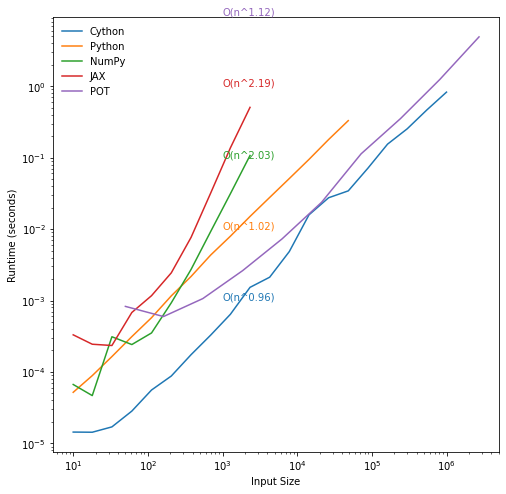

In [ ]:
# Do power law fits and extract the exponents with uncertainties
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

def fit_power_law(x, y):
    popt, pcov = curve_fit(power_law, x, y)
    return popt, np.sqrt(np.diag(pcov))

cython_exponent, cython_exponent_err = fit_power_law(sizes, cython_runtimes)
python_exponent, python_exponent_err = fit_power_law(sizes[:15], python_runtimes)
numpy_exponent, numpy_exponent_err = fit_power_law(sizes[:10], numpy_runtimes)
jax_exponent, jax_exponent_err = fit_power_law(sizes[:10], jax_runtimes)
POT_exponent, POT_exponent_err = fit_power_law(sizes[:10]**2/2, POT_runtimes)

print(f"Cython exponent: {cython_exponent[1]:.3f} ± {cython_exponent_err[1]:.3f}")
print(f"Python exponent: {python_exponent[1]:.3f} ± {python_exponent_err[1]:.3f}")
print(f"NumPy exponent: {numpy_exponent[1]:.3f} ± {numpy_exponent_err[1]:.3f}")
print(f"JAX exponent: {jax_exponent[1]:.3f} ± {jax_exponent_err[1]:.3f}")
print(f"POT exponent: {POT_exponent[1]:.3f} ± {POT_exponent_err[1]:.3f}")

# Plot the average runtimes with error bars to show the standard deviation

import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
plt.errorbar(sizes, cython_runtimes, label="Cython")
plt.errorbar(sizes[:15], python_runtimes, label="Python")
plt.errorbar(sizes[:10], numpy_runtimes, label="NumPy")
plt.errorbar(sizes[:10], jax_runtimes, label="JAX")
plt.errorbar(sizes[:10]**2 / 2, POT_runtimes, label="POT")

plt.xlabel("Input Size")
plt.ylabel("Runtime (seconds)")
plt.legend(frameon = False)

# Add the power law exponent near each line with O(n^exponent) notation in the same color
plt.text(1e3, 1e-3, f"O(n^{cython_exponent[1]:.2f})", color="C0")
plt.text(1e3, 1e-2, f"O(n^{python_exponent[1]:.2f})", color="C1")
plt.text(1e3, 1e-1, f"O(n^{numpy_exponent[1]:.2f})", color="C2")
plt.text(1e3, 1e0, f"O(n^{jax_exponent[1]:.2f})", color="C3")
plt.text(1e3, 1e1, f"O(n^{POT_exponent[1]:.2f})", color="C4")

plt.xscale("log")
plt.yscale("log")








109 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


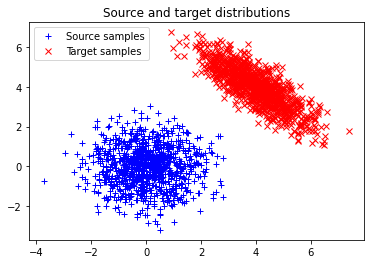

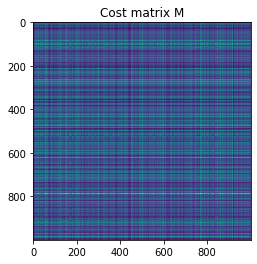

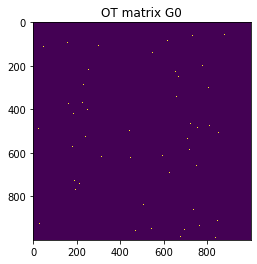

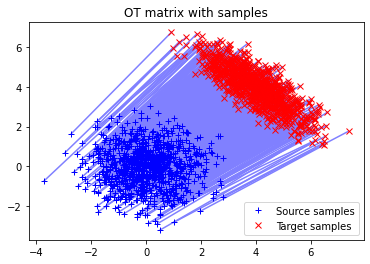

In [ ]:
import ot.plot

n = 1000  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)


plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('Source and target distributions')

plt.figure(2)
plt.imshow(M, interpolation='nearest')
plt.title('Cost matrix M')

G0 = ot.emd(a, b, M)

plt.figure(3)
plt.imshow(G0, interpolation='nearest')
plt.title('OT matrix G0')

plt.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('OT matrix with samples')


# functio to test the runtime of ot.emd
def test_emd(n):
    mu_s = np.array([0, 0])
    cov_s = np.array([[1, 0], [0, 1]])

    mu_t = np.array([4, 4])
    cov_t = np.array([[1, -.8], [-.8, 1]])

    xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

    a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

    # loss matrix
    M = ot.dist(xs, xt)
    return ot.emd(a, b, M)

%timeit test_emd(1000)

In [ ]:
# Use jax to vmap each function and test

import jax.numpy as jnp
from jax import vmap

# jax_find_indices_cython = vmap(find_indices_cython, in_axes=(0, None))
jax_find_indices_python = vmap(find_indices_python, in_axes=(0, None))
jax_find_indices_numpy = vmap(find_indices_numpy, in_axes=(0, None))

# jax_cython_runtimes = get_runtimes(jax_find_indices_cython, sizes, verbose=False)
jax_python_runtimes = get_runtimes(jax_find_indices_python, sizes[:10], verbose=False)
jax_numpy_runtimes = get_runtimes(jax_find_indices_numpy, sizes[:10], verbose=False)



IndexError: tuple index out of range